Numba is an open source JIT(just in time) compiler, that attempts to translate Python and NumPy code into fast machine code.

In this notebook I will try to highlight how to use Numba, some common pitfalls to avoid and a few tips and tricks to help you along the way.

<div>

</div>

The Mandelbrot set is a very good example to use when explaining why JIT compilation can be greatly beneficial when we have to do many calculations over and over again. 

The Mandelbrot set is the set obtained from the quadratic recurrence equation
$z_{n+1} = z_{n}^{2} + c$ with $z_{0} = c$, where points $c$ in the complex plane for which the orbit of $z_{n}$ does not tend to infinity are in the set.[<sup>1</sup>](#fn1) 

This means that we make a grid of the complex plane, and then iterate over the points in this grid with this function $n$ times, where $n$ is an integer larger than $2$.

But when do we know when the point will tend towards infinity? This is surprisingly simple, we only need to know if the *modulus* of the current number is greater than $2$. This means that we check that $|z| = \sqrt{Re(z)^{2} + Im(z)^{2}} \leq 2$.

Now, on to the actual code!

First we import some usefull packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
from numba import jit

Then we define a simple function to deal with the calculations to be run on the relevant numbers

In [2]:
def mandelbrot_func(z, n_max):
    """
    Iterates over the complex number z up to n_max times.

    Arguments:
        z {complex number} -- Complex number to be iterated
        n_max {int} -- The maximum number of iterations to run

    Outputs:
        i {int} -- How many iterations it took for the number z to "escape"
        0 {int} -- returns 0 if the number z did not "escape" after n_max iterations
    """
    c = z
    for i in range(int(n_max)):
        if np.sqrt((z.real ** 2) + (z.imag ** 2)) >= 2:
            return i
        z = z*z + c
    return 0 #n_max

This is a pretty straight forward implementation of the Mandelbrot function, so let's test it!

We could simply do a `timeit` call for a number we know is in the set, but to actually test the function we should run it over a grid several times, so let's make a function to do this!

In [3]:
def mandelbrot_set(func, ranges, dim, n_max):
    """
    desc

    Arguments:
        func {function} -- The function to use for the iteration
        ranges {list} -- list with the minimum and maximum x 
                         and y values to generate a grid from
        dim {list} -- a list containing the width and height
                      of the grid, the amount of points to
                      generate in the x and y directions
        n_max {int} -- the maximum number of iterations to
                       run per point of the grid

    Outputs:
        x {array} -- array with the Real number values of the grid
        y {array} -- array with the Imaginary number values of the grid
        m_xy {array} -- array of the values returned from the iteration function
    """
    x_min, x_max, y_min, y_max = ranges
    w, h = dim
    x = np.linspace(x_min, x_max, int(w))
    y = np.linspace(y_min, y_max, int(h))

    m_xy = np.zeros((int(w), int(h)))
    for i in range(int(w)):
        for j in range(int(h)):
            num = complex(x[i], y[j])
            m_xy[i, j] = func(num, n_max)

    return x, y, m_xy

This function takes in values to generate a grid of complex numbers, and then sends each point to a function that will iterate over that point. So now let's set up our grid!

In [4]:
r = [-2,2,-2,2]
d = [1e2,1e2]
n = 50
n_repeat = 100
n_vals = np.arange(1, n_repeat+1, 1)

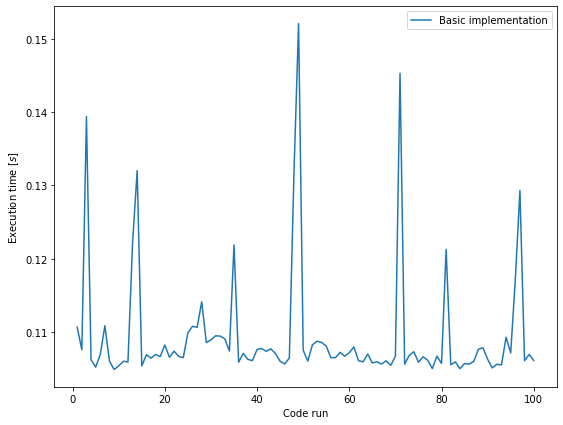

In [5]:
time_py = timeit.repeat(stmt="mandelbrot_set(mandelbrot_func,r,d,n)",
                        setup="from __main__ import mandelbrot_set, mandelbrot_func, r, d, n",
                        number=1,repeat=n_repeat)

plt.figure(1, figsize=(9,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

In [6]:
def mandelbrot_func_improved(z, n_max):
    c = z
    for i in range(int(n_max)):
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
        z = z*z + c
    return 0 #n_max

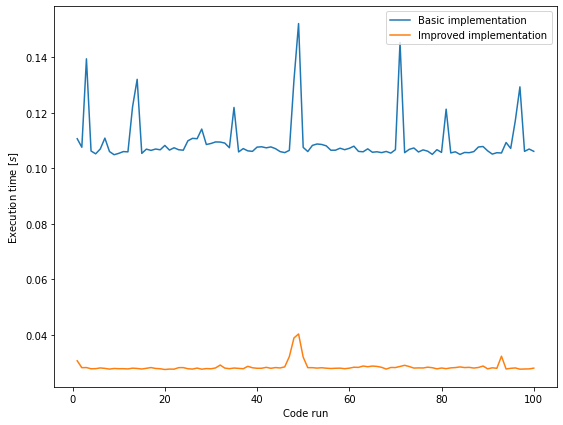

In [7]:
time_py_imp = timeit.repeat(stmt="mandelbrot_set(mandelbrot_func_improved,r,d,n)",
                            setup="from __main__ import mandelbrot_set, mandelbrot_func_improved, r, d, n",
                            number=1,repeat=n_repeat)

plt.figure(2, figsize=(9,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.plot(n_vals, time_py_imp, label = "Improved implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

In [8]:
@jit(nopython = True)
def mandelbrot_func_jit(z, n_max):
    c = z
    for i in range(int(n_max)):
        if (z.real * z.real + z.imag * z.imag) >= 4:
            return i
        z = z*z + c
    return 0 #n_max

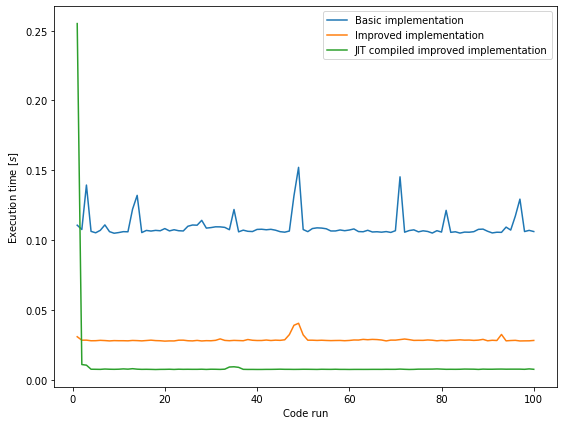

In [9]:
time_jit = timeit.repeat(stmt="mandelbrot_set(mandelbrot_func_jit,r,d,n)",
                         setup="from __main__ import mandelbrot_set, mandelbrot_func_jit, r, d, n",
                         number=1,repeat=n_repeat)

plt.figure(3, figsize=(9,7))
plt.plot(n_vals, time_py, label = "Basic implementation")
plt.plot(n_vals, time_py_imp, label = "Improved implementation")
plt.plot(n_vals, time_jit, label = "JIT compiled improved implementation")
plt.xlabel("Code run")
plt.ylabel(r"Execution time $[s]$")
plt.legend(loc = 1)
plt.show()

In [10]:
def mandelbrot_image(func, ranges, dim, n_max, img_spec):
    a, b, c = mandelbrot_set(func, ranges, dim, n_max)
    width, height, cmap = img_spec
    fig2 = plt.figure(1,figsize=(width,height))
    ax2 = fig2.add_subplot(1,1,1,label="2")
    ax2.imshow(c.T,cmap=cmap)

In [11]:
img = [5,5, "inferno"]
d_2 = [1e3, 1e3]

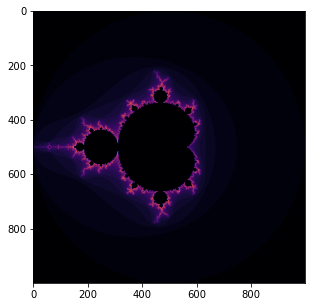

In [12]:
mandelbrot_image(mandelbrot_func,r , d_2, n, img)

In [ ]:
mandelbrot_image(mandelbrot_func_improved,r , d_2, n, img)

In [ ]:
mandelbrot_image(mandelbrot_func_jit,r , d_2, n, img)

Mandelbrot set WolframMathWorld: The earlier definition of the set is taken from here.   
<span id="fn1"> https://mathworld.wolfram.com/MandelbrotSet.html</span>


Official Numba documentation can be found here:  
http://numba.pydata.org/  
http://numba.pydata.org/numba-doc/0.12.2/index.html

Compiling Python code with `@jit`  
https://numba.readthedocs.io/en/stable/user/jit.html?